### Imports

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import keras as keras
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import plot_model
from keras.datasets import mnist

## Residual blocks in Keras

The key idea behind ResNet is the residual block. Instead of learning the output directly, the network learns the residual, or the difference between the output and the input. The output is then formed by adding this residual to the input. This makes it easier for the network to learn the identity mapping (i.e., passing the input unchanged if needed).

This way, the residual block learns a residual function $F(x) + x = H(x)$ So the block outputs $F(x) + x = H(x)$


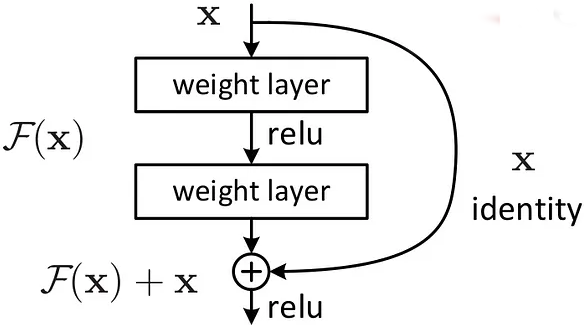

## Merging layers in Keras

 * [Documentation](https://keras.io/api/layers/merging_layers/)  
 * It allows to combine multiple layers into one layer
 * We have the following merge layers:
   1. Concatenate,
   2. Average,
   3. Maximum,
   4. Minimum,
   5. Add,
   6. Subtract,
   7. Multiply,
   8. Dot

Except for the dot layer, it takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).

## Skip connection in Keras

We need an `add()` layer to skip a connection in Keras

<img src="images/addLayer.png" width="500"/>

In [7]:
input_shape = (2, 3, 4) # 2 batches, 3 rows, 4 columns

x1 = np.random.rand(*input_shape)
x2 = np.random.rand(*input_shape)

y = keras.layers.Add()([x1, x2]) # Just adds all the corresponding elements of each tensor to return one instead.

# print("x1:")
# print(x1)
# print("\nx2:")
# print(x2)
# print("\ny:")
# print(y)

## Batch Normalization


 * The distribution of the inputs to layers somewhere down in the network may change after each mini-batch when the weights are refreshed.
 * This can make the learning algorithm always pursue a moving target.
 * Batch normalization gives a way to prevent such strong shifting
 * It does this by scaling the output of the layer, explicitly by normalizing the activations of each input variable per mini-batch
 * This typically has the impact of stabilizing and accelerating the training procedure of deep neural networks

    <img src="images/batchNormalization.png" width=600 >


## Plain & Residual Blocks

We now define a **residual block** along with a **plain** one, bith using *batch normalization* after each convolutional layer. The number of filters and their size is parameterized.

In [ ]:
def resblock(x, kernelsize, filters):
    fx = Conv2D( # First Conv layer
        filters,
        kernelsize,
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(x)

    fx = BatchNormalization()(fx) # Apply Batch normalization to first conv layer

    fx = Conv2D( # Second Conv layer
        filters,
        kernelsize,
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(fx)

    out = Add()([x,fx]) # Skip connection
    #out = ReLU()(out)
    out = BatchNormalization()(out) # Apply Batch normalization to the output of the skip connection
    return out

def plainblock(x, kernelsize, filters):
    fx = Conv2D(
        filters,
        kernelsize,
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(x)

    fx = BatchNormalization()(fx)

    fx = Conv2D(
        filters,
        kernelsize,
        kernel_initializer='he_normal',
        activation='relu',
        padding='same'
    )(fx)

    #out = ReLU()(fx)
    out = BatchNormalization()(fx)
    return out

Plain Model Definition

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
#Adding the channel dimension
n_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"n_classes:{n_classes}, input_shape:{input_shape}")

n_classes:10, input_shape:(28, 28, 1)


* `plain_model` defines the model without skipping connections
* The number of plain blocks to be added is regulated by the argument `nblocks`

In [ ]:

# Defining the plain model. Stacks two blocks having nblocks plain blocks
def plain_model(filters, kernelsize, nblocks, n_classes):
  input = tf.keras.Input(shape=input_shape)
  hid = Conv2D(filters[0],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(input)
  for _ in range(nblocks):
    hid = plainblock(hid, kernelsize, filters[0])

  hid = Conv2D(filters[1],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(hid)
  for _ in range(nblocks):
    hid = plainblock(hid, kernelsize, filters[1])

  hid = MaxPooling2D(pool_size=(2, 2))(hid) # downsizing images
  hid = Flatten()(hid) # flattening output feature maps
  # adding a Dense layer of 128 neurons with relu
  hid = Dense(32, activation='relu', use_bias=True)(hid)
  #Implementing dropout regularization with p = 0.2
  hid = Dropout(0.2)(hid)
  hid = Dense(16, activation='relu', use_bias=True)(hid)
  hid = Dropout(0.2)(hid)
  output = Dense(n_classes,activation=tf.nn.softmax)(hid)
  model = Model(input, output)
  return model

# Set a fixed seed for Python's built-in random module
random.seed(123)
# Set a fixed seed for NumPy
np.random.seed(123)
# Set a fixed seed for TensorFlow
tf.random.set_seed(123)

filters = [8, 8]
kernelsize = 3
nblocks = 10

model = plain_model(filters, kernelsize, nblocks, n_classes)
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 76,210 (297.70 KB)

 Trainable params: 75,570 (295.20 KB)

 Non-trainable params: 640 (2.50 KB)

None


## Train the network with Plain Model

* We now train the model having $10$ concolutional blocks plus two dense layers before the output one, for a total of $23$ layers.
* We use Adam optimizer with `clipvalue` and a fixed learning rate.
* Since we are not selecting hyperparameters, we can directly evaluate the testing performance.

In [ ]:
# training the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3,clipvalue=0.75),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x=X_train,y=y_train,
    epochs=15,
    batch_size = 128,
    validation_data=(X_test, y_test)
)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - accuracy: 0.1358 - loss: 2.3079 - val_accuracy: 0.2037 - val_loss: 21.1618
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7260 - loss: 0.7892 - val_accuracy: 0.7957 - val_loss: 0.7938
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.8698 - loss: 0.4078 - val_accuracy: 0.8303 - val_loss: 0.6410
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8980 - loss: 0.3199 - val_accuracy: 0.9085 - val_loss: 0.3314
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9072 - loss: 0.2847 - val_accuracy: 0.9444 - val_loss: 0.2409
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9192 - loss: 0.2487 - val_accuracy: 0.9675 - val_loss: 0.1195
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9312 - loss: 0.2394 - val_accuracy: 0.9723 - val_loss: 0.1292
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9369 - loss: 0.2231 -

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Loss subplot
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Learning Curve - Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Accuracy subplot
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Learning Curve - Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

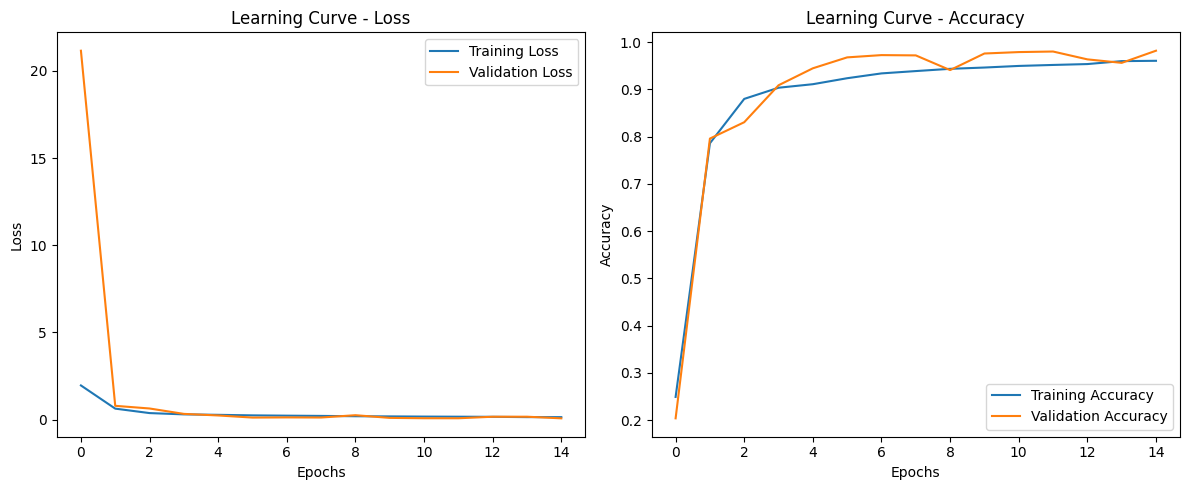

In [ ]:
plot_history(history)

## Train the network with ResNet

* `residual_model` defines the model using skip connections, like ResNet
* Like for the plain model, the number of plain blocks to be added is regulated by the argument `nblocks`

In [ ]:
# Defining the residual model. Stacks two blocks having nblocks residual blocks

def residual_model(filters, kernelsize, nblocks, n_classes):
  input = tf.keras.Input(shape=input_shape)

  hid = Conv2D(filters[0],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(input)
  for _ in range(nblocks):
    hid = resblock(hid, kernelsize, filters[0])

  hid = Conv2D(filters[1],
              kernel_size=kernelsize,
              input_shape = input_shape,
              padding = "same")(hid)
  for _ in range(nblocks):
    hid = resblock(hid, kernelsize, filters[1])

  hid = MaxPooling2D(pool_size=(2, 2))(hid) # downsizing images
  hid = Flatten()(hid) # flattening output feature maps
  # adding a Dense layer of 128 neurons with relu
  hid = Dense(32, activation=tf.nn.relu, use_bias=True)(hid)
  #Implementing dropout regularization with p = 0.2
  hid = Dropout(0.2)(hid)
  hid = Dense(16, activation=tf.nn.relu, use_bias=True)(hid)
  hid = Dropout(0.2)(hid)
  output = Dense(n_classes,activation=tf.nn.softmax)(hid) # addin
  model = Model(input, output)
  return model


random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

filters = [8, 8]
kernelsize = 3
nblocks = 10
model = residual_model(filters, kernelsize, nblocks, n_classes)
print(model.summary())



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 28, 28, 8) │         80 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 28, 28, 8) │        584 │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28, 8) │          0 │ conv2d_42[0][0],  │
│                     │                   │            │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ add_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 28, 8) │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ add_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 28, 28, 8) │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ add_3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 28, 28, 8) │        584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28, 8) │         32 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 76,210 (297.70 KB)

 Trainable params: 75,570 (295.20 KB)

 Non-trainable params: 640 (2.50 KB)

None


In [ ]:
# training the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3, clipvalue=0.75),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_res = model.fit(x=X_train,y=y_train,
          epochs=15,
          batch_size = 128,
          validation_data=(X_test, y_test))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 76ms/step - accuracy: 0.5364 - loss: 1.3135 - val_accuracy: 0.6680 - val_loss: 1.6779
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.9131 - loss: 0.2856 - val_accuracy: 0.8412 - val_loss: 0.6918
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9351 - loss: 0.2170 - val_accuracy: 0.9550 - val_loss: 0.1871
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9461 - loss: 0.1828 - val_accuracy: 0.9828 - val_loss: 0.0594
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9544 - loss: 0.1589 - val_accuracy: 0.9599 - val_loss: 0.1780
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9606 - loss: 0.1388 - val_accuracy: 0.9797 - val_loss: 0.0806
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9630 - loss: 0.1336 - val_accuracy: 0.9827 - val_loss: 0.0666
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9657 - loss: 0.1256 - 

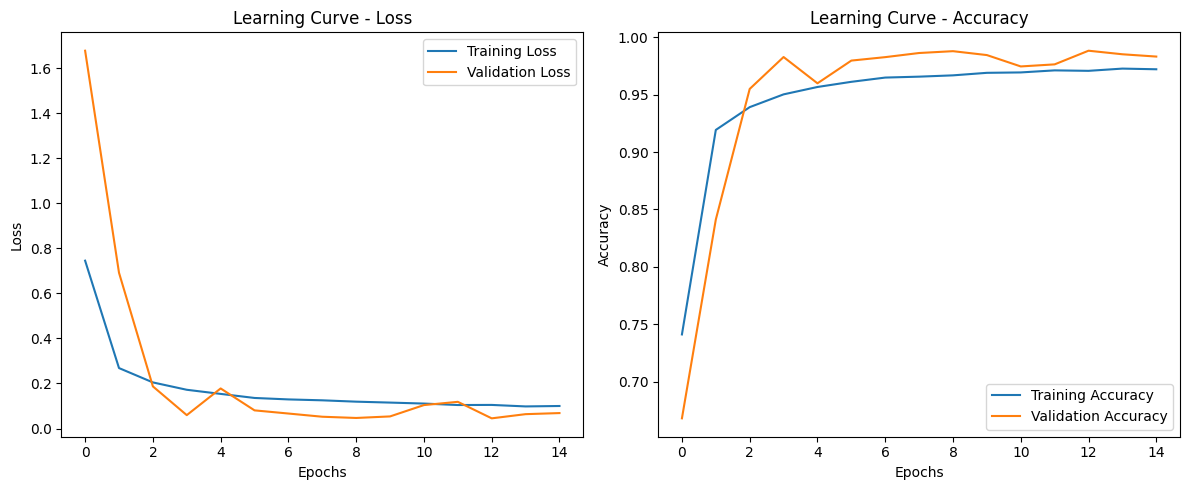

In [ ]:
plot_history(history_res)

## Conclusion

 We reach to the conclusion that the residual model has a better training by looking at the training loss curve and final value.
  * It starts from the beginning with a more consistent training, from the same initialized model!
  * Much smaller final loss $0.0881$ vs $0.1631$
  * The test performance confirm it.

## Inception layers in Keras

Inception layers are designed to capture different types of features from the same input image. Rather than using a single convolutional filter size, Inception layers apply multiple convolutions with different kernel sizes and pooling operations.

*  We use another *merge* layer, the `concatenate` one, to concatenate the feature maps of the convolutional layers working at the same level in the *inception layer*.
* `filters`: numbers of filters to be used in each convolutional layer
* `kernel_size`: size of the kernel to be used in each conv layer
* `shrink_size`: number of filters to be used in each $1\times 1$ convolutional layer
* To define the final model, we need to use the `Model` class

<img width=500 src="images/concatenateClass.png" />


The axis parameter determines which axis the concatenation is performed on. The key point is that only one axis can differ—all other dimensions must be the same.

<div style={{ display: "flex" }}>
<img width=450 src="images/concatenateA.png" />
<img width=450 src="images/concatenateB.png" />
<img width=450 src="images/concatenateC.png" />
</div>

In [5]:
def inception_block(prev_layer, filters,  kernelsize, shrink_size):

  layer_1 = Conv2D(filters=shrink_size[0], kernel_size=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu',
                  name='Central1')(prev_layer)
  layer_1 = Conv2D(filters=filters[0], kernel_size=kernelsize[0],
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu')(layer_1)
  layer_2 = Conv2D(filters=shrink_size[1], kernel_size=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu',
                  name='Central2')(prev_layer)
  layer_2 = Conv2D(filters=filters[1], kernel_size=kernelsize[1],
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu')(layer_2)

  layer_3 = MaxPooling2D(pool_size=kernelsize[2], strides=(1,1),
                        padding='same',
                        name='MaxPooling')(prev_layer)

  layer_3 = Conv2D(filters=shrink_size[2], kernel_size=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu')(layer_3)

  layer_4 = Conv2D(filters=shrink_size[3], kernel_size=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu',
                  name='1by1Conv')(prev_layer)

  # output layer
  mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
  # The axis parameter determines which axis the concatenation is performed on.
  return mid_1

def incept_model(input_shape,
                n_classes,
                filters,
                kernelsize,
                densesize,
                shrink_size):
  input_img = Input(shape=input_shape)
  ## first layer 3x3 64 filters
  prev_layer = Conv2D(filters=8, kernel_size=(3,3), padding='same',
                      kernel_initializer='he_normal',
                      activation='relu')(input_img)
  inc = inception_block(prev_layer, filters, kernelsize, shrink_size)
  pool = MaxPooling2D(pool_size=(2, 2))(inc)
  flat_1 = Flatten()(pool)
  dense_1 = Dense(densesize[0], activation='relu')(flat_1)
  dr = Dropout(0.2)(dense_1)
  dense_2 = Dense(densesize[1], activation='relu')(dr)
  dr = Dropout(0.2)(dense_2)
  output = Dense(n_classes, activation='softmax')(dr)
  model = Model(input_img, output)
  return model



We initialize the model so as to have a similar number of parameters as the previous plain and residual models (~75k).

In [6]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
filters = [4, 4]
shrink_size = [2, 2, 2, 2]
kernelsize = [2, 3, 4]
densesize = [32, 16]

model = incept_model(input_shape = input_shape,
                     n_classes = n_classes,
                     filters = filters,
                     kernelsize = kernelsize,
                     densesize = densesize,
                     shrink_size = shrink_size)
print(model.summary())

NameError: name 'random' is not defined

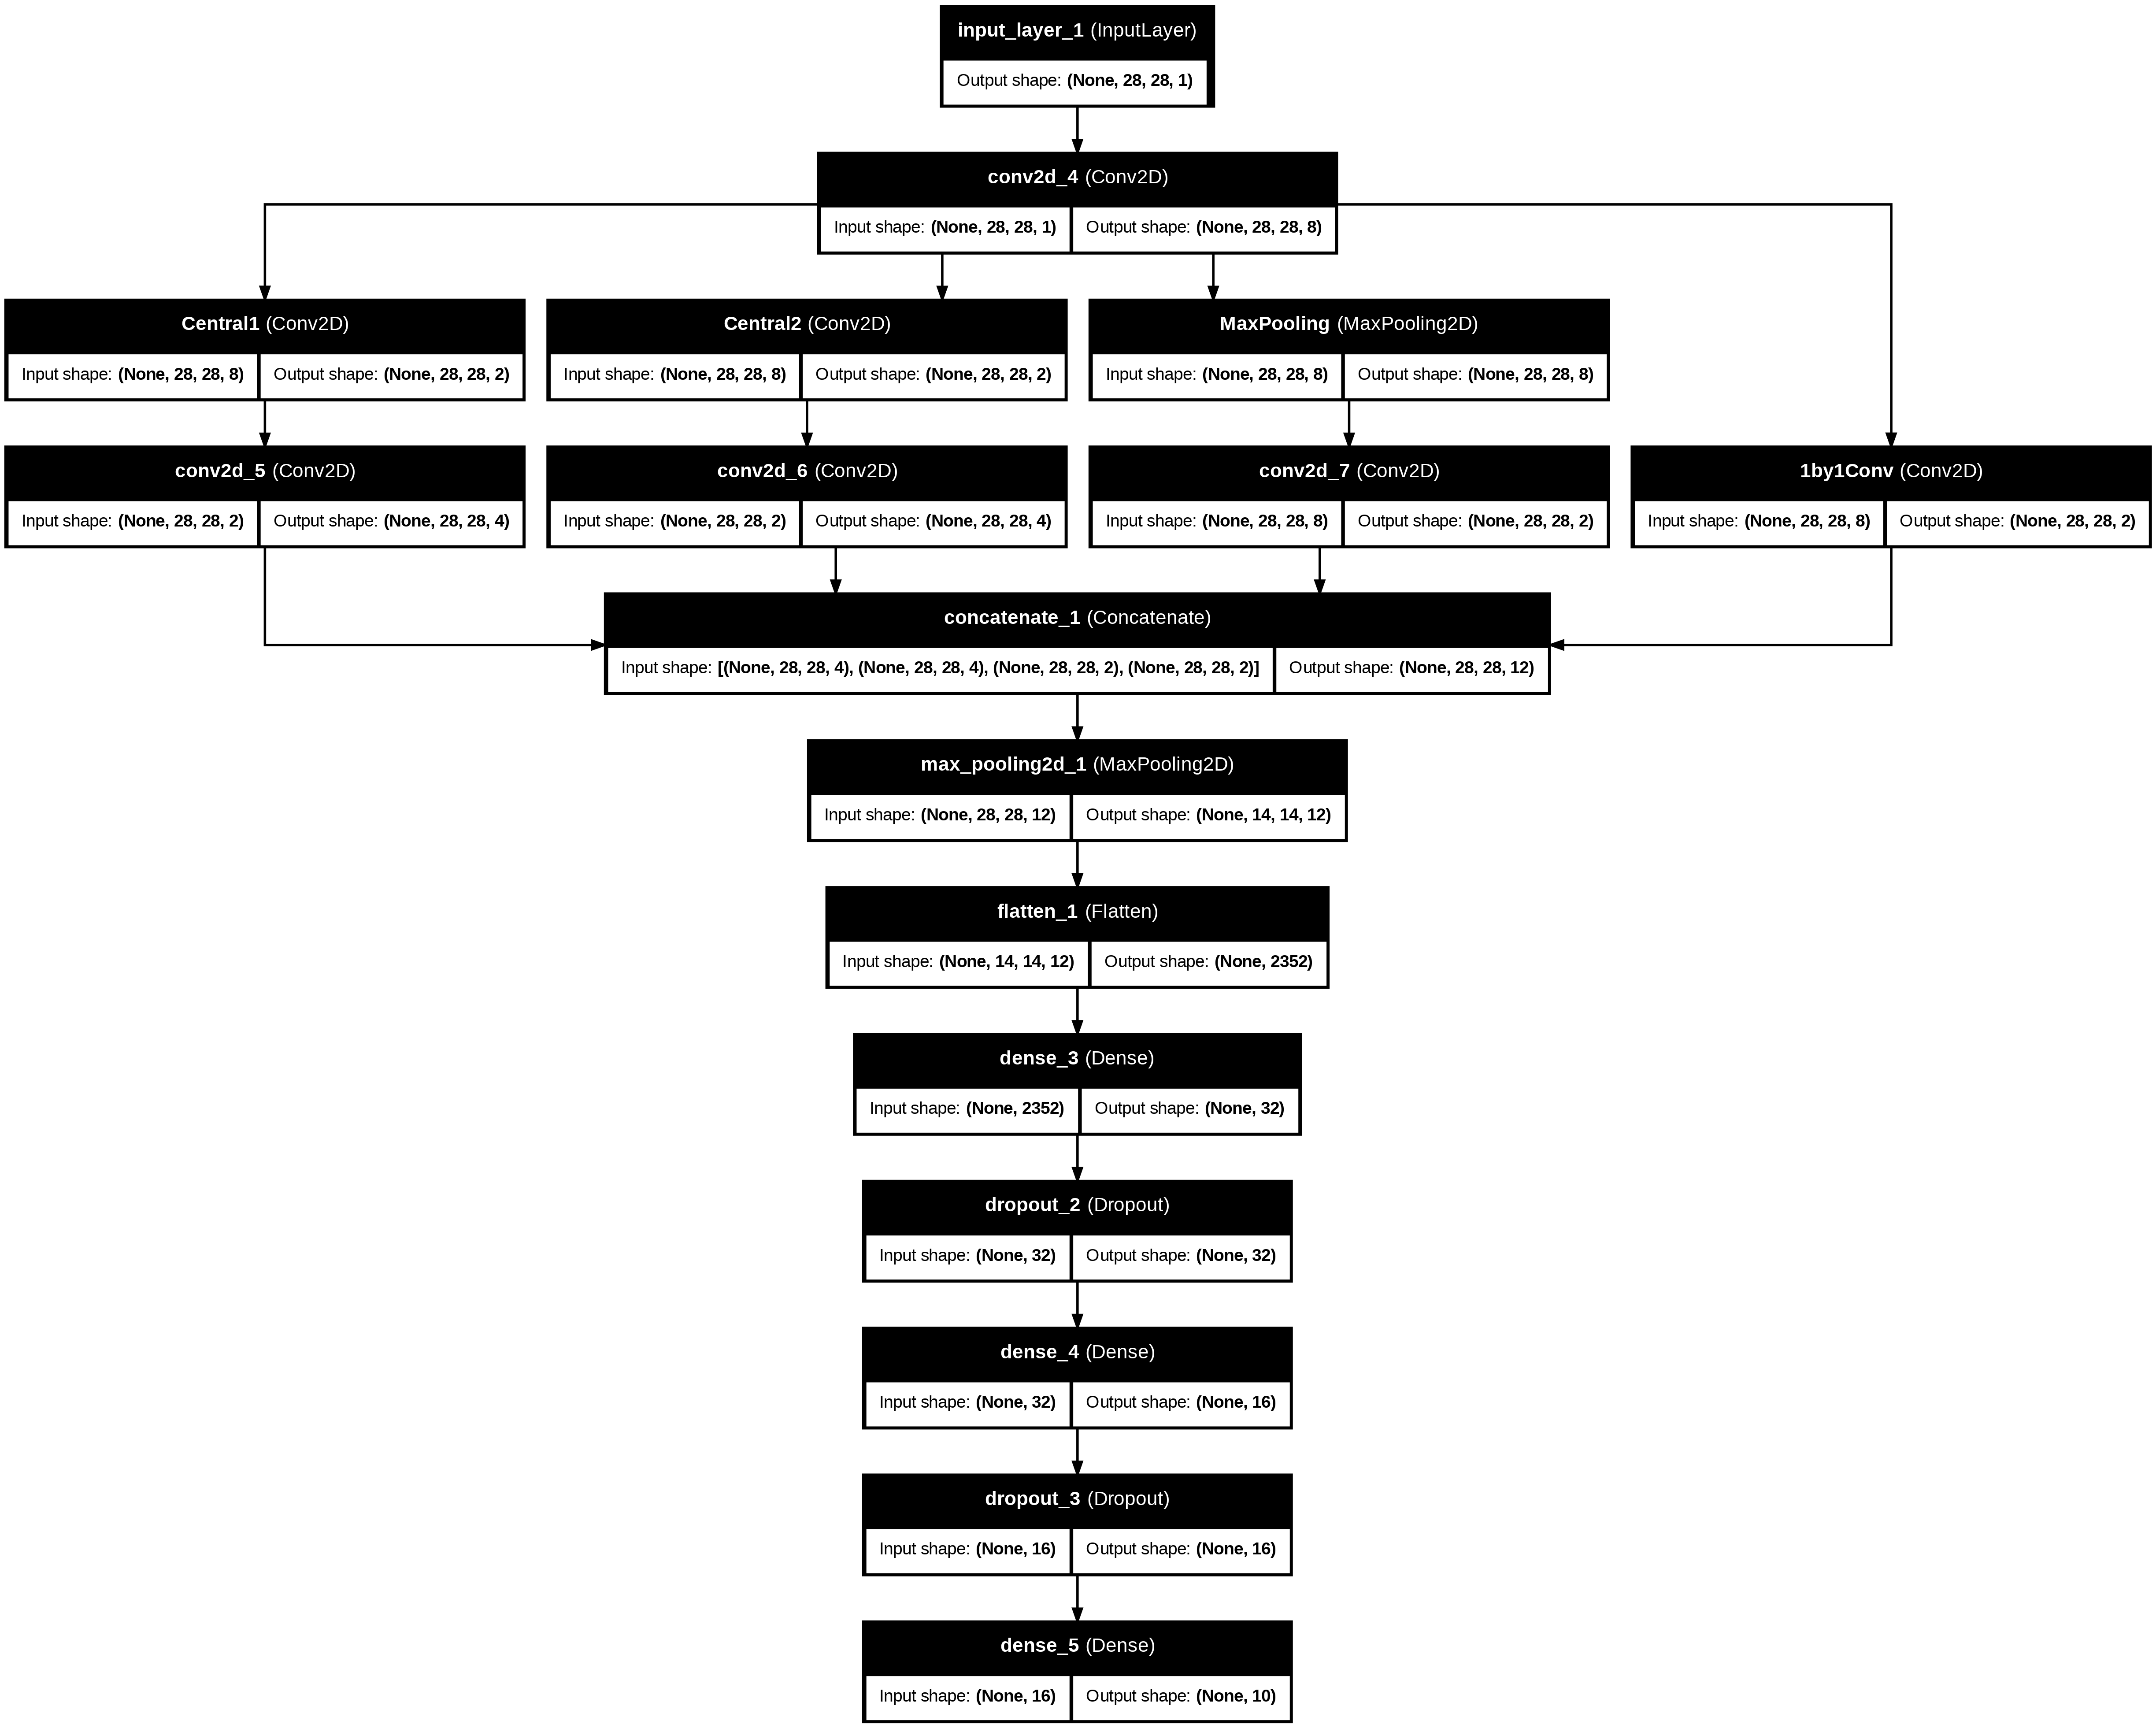

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Train with Inception Layer

Training with the same configuration and optimizer as before, using the same `clipvalue` value.

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-3,clipvalue=0.75),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(x=X_train,y=y_train,
          epochs=15,
          batch_size = 128,
          validation_data=(X_test, y_test))


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.2542 - loss: 6.6951 - val_accuracy: 0.6397 - val_loss: 1.0579
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5020 - loss: 1.3242 - val_accuracy: 0.7219 - val_loss: 0.8534
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5629 - loss: 1.1689 - val_accuracy: 0.7414 - val_loss: 0.7454
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5947 - loss: 1.0749 - val_accuracy: 0.7563 - val_loss: 0.6643
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6182 - loss: 1.0128 - val_accuracy: 0.8457 - val_loss: 0.4883
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6987 - loss: 0.8518 - val_accuracy: 0.8551 - val_loss: 0.4515
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7230 - loss: 0.7870 - val_accuracy: 0.8629 - val_loss: 0.4122
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7293 - loss: 0.7713 - val_accuracy: 

Since it is les deep, each epoch is faster. However, it seem too inaccurate, let's try to vary the learning rate and number of epochs.

In [19]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
filters = [4, 4]
shrink_size = [2, 2, 2, 2]
kernelsize = [2, 3, 4]
densesize = [32, 16]

model = incept_model(input_shape = input_shape,
                     n_classes = n_classes,
                     filters = filters,
                     kernelsize = kernelsize,
                     densesize = densesize,
                     shrink_size = shrink_size)
# training the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4,clipvalue=1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x=X_train,y=y_train,
          epochs=60,
          batch_size = 128,
          validation_data=(X_test, y_test))


Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.2302 - loss: 5.8546 - val_accuracy: 0.6383 - val_loss: 1.1338
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5386 - loss: 1.3664 - val_accuracy: 0.7595 - val_loss: 0.7736
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6209 - loss: 1.1144 - val_accuracy: 0.7821 - val_loss: 0.6660
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6497 - loss: 1.0057 - val_accuracy: 0.7966 - val_loss: 0.5986
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6873 - loss: 0.8984 - val_accuracy: 0.9091 - val_loss: 0.4094
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7367 - loss: 0.7899 - val_accuracy: 0.9240 - val_loss: 0.3448
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7527 - loss: 0.7279 - val_accuracy: 0.9287 - val_loss: 0.3285
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7593 - loss: 0.7110 - val_accuracy: 